In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from utils import buffer
from scipy.fftpack import dct,idct

CRP Feature method
create halftone filter for midi notes

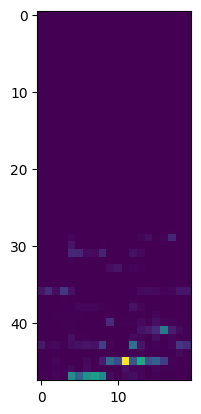

In [49]:
# chroma feature
nCRP = 55 # bzw. vgl. mit  35 :);   % CRP(nCRP)
fs = 44100
N = int(4*8192)
overlap = N // 2
midi_note_start = 12
midi_note_stop = 120

k = np.arange(0,N//2 + 1)
fk = k*(fs/N)  # DFT-bin frequencies
midi_note_number_frequencies = 12* np.log2((fk/440)+np.finfo(float).eps)+69
Hp = np.zeros((fk.shape[0],midi_note_stop - midi_note_start),dtype=float)
for i, midi_note_number in enumerate(range(12,120)):
    d = np.abs(midi_note_number - midi_note_number_frequencies)
    Hp[:,i] = 0.5 * np.tanh(np.pi * (1 - 2*d)) + 0.5

if False:
    fig,ax = plt.subplots()
    ax.plot(fk,Hp[:,-8:-3])  # plot some of the halftone filters
    plt.title("Halftone Filters")
    ax.set_xlabel("Frequency in Hz")
    ax.set_xlim(5000,7000)

y,_ = librosa.load("/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/12_-_Let_It_Be/06_-_Let_It_Be.wav",sr = fs)
#y,_ = librosa.load("/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/12_-_Let_It_Be/03_-_Across_the_Universe.wav",sr = fs,duration = 10)

window = np.hanning(N)
y_blocks = buffer(y,N,overlap,0,window) 
weight = np.sum(window)
y_spectrum = (2/weight) * np.abs(np.fft.rfft(y_blocks,axis=0))
pitch_gram = np.matmul(Hp.T, y_spectrum) ** 2   # np.power(X,2) 
dt = np.linspace(0,y.shape[0]/fs,y_blocks.shape[1],10)
df = np.array(440*(2 ** ((np.linspace(midi_note_start,midi_note_stop,10)-69)/12)),dtype=int)
y_ticks = np.linspace(0,midi_note_stop-midi_note_start,10)



v = np.finfo(float).eps * np.ones((120,pitch_gram.shape[1]))
v[12:,:] = pitch_gram

vLog = np.log(100*v + 1);    # cf. CLP-Measure  .... diese Größe einfach zu Chroma zusammenfalten => quasi Lautheitsbewertet ...
vLogDCT = dct(vLog,norm='ortho',axis=0);  
vLogDCT[:nCRP,:] = 0  # liftering hochpass
vLogDCT[nCRP,:] = 0.5*vLogDCT[nCRP,:]

vLog_lift=idct(vLogDCT,norm='ortho',axis=0)
vLift = 1/100*(np.exp(vLog_lift)-1); 
crp = vLift.reshape(10,12,-1)
crp = np.maximum(0,np.sum(crp,axis=0))
crp = crp / np.sum(crp,axis=0)

fig,ax = plt.subplots()
img = ax.imshow(crp,origin='lower')
ax.set_xlim(0,30)
plt.show()


UsageError: Cell magic `%%` not found.
